In [5]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [6]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


RMSE: 4.551213156394614


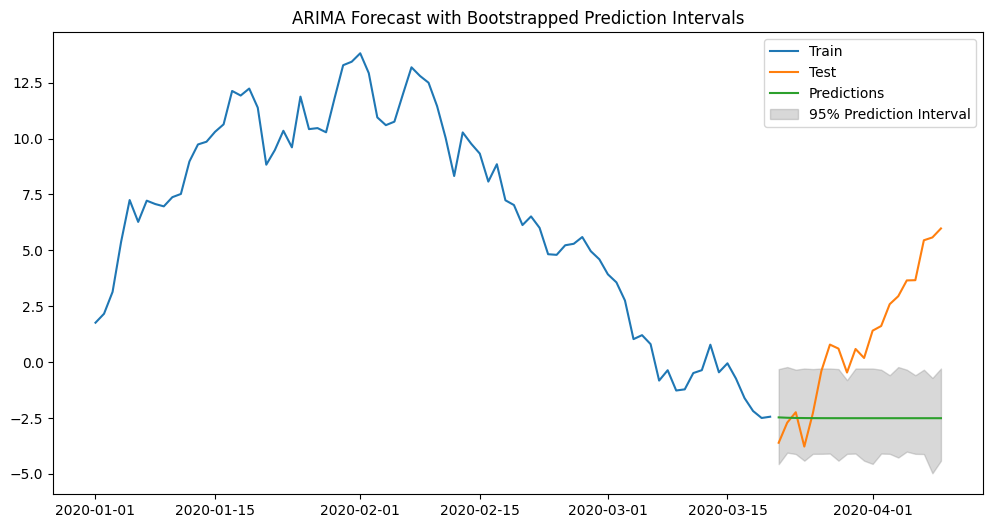

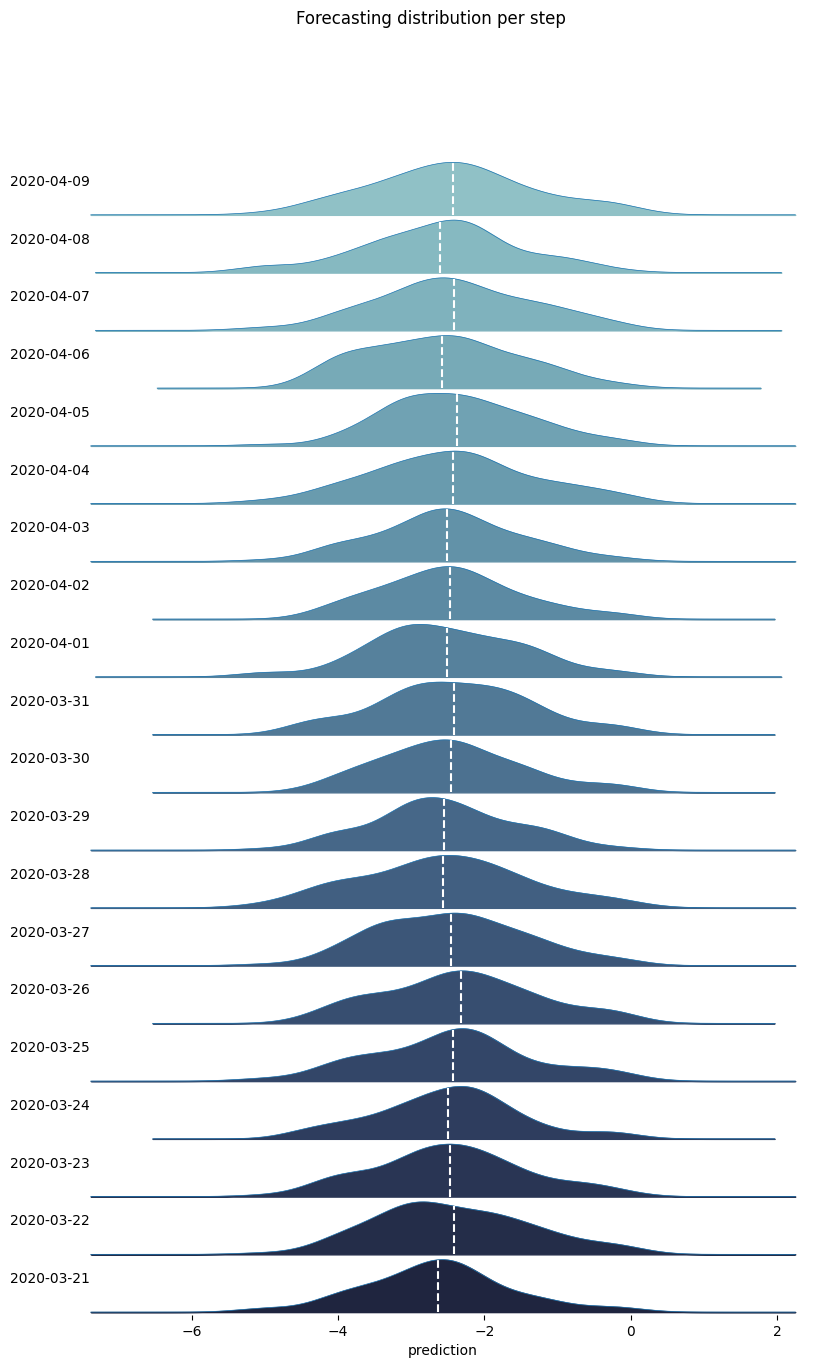

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from typing import Optional, Union, Any
import matplotlib.pyplot as plt
import seaborn as sns

class ARIMAForecaster:
    def __init__(self, order=(1,1,1)):
        self.order = order
        self.model = None
        self.fitted = False
        self.in_sample_residuals = None
        self.last_window = None
        self.transformer_y = None

    def fit(self, y):
        self.model = ARIMA(y, order=self.order)
        self.fitted_model = self.model.fit()
        self.fitted = True
        self.in_sample_residuals = self.fitted_model.resid
        self.last_window = y[-self.order[0]:] if self.order[0] > 0 else y[-1:]

    def predict(self, steps):
        if not self.fitted:
            raise ValueError("Model must be fitted before prediction")
        return self.fitted_model.forecast(steps)

    def _recursive_predict(self, steps, last_window, exog=None):
        return self.fitted_model.forecast(steps=steps, exog=exog)

    def predict_bootstrapping(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> pd.DataFrame:
        if not self.fitted:
            raise ValueError("Model must be fitted before bootstrapping")

        if last_window is None:
            last_window = self.last_window.copy()

        boot_predictions = np.full(
            shape=(steps, n_boot),
            fill_value=np.nan,
            dtype=float
        )
        rng = np.random.default_rng(seed=random_state)
        seeds = rng.integers(low=0, high=10000, size=n_boot)

        residuals = self.in_sample_residuals

        for i in range(n_boot):
            last_window_boot = last_window.copy()
            exog_boot = exog.copy() if exog is not None else None

            rng = np.random.default_rng(seed=seeds[i])
            sample_residuals = rng.choice(
                a=residuals,
                size=steps,
                replace=True
            )

            for step in range(steps):
                prediction = self._recursive_predict(
                    steps=1,
                    last_window=last_window_boot,
                    exog=exog_boot
                )

                prediction_with_residual = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual

                last_window_boot = np.append(
                    last_window_boot[1:],
                    prediction_with_residual
                )

                if exog is not None:
                    exog_boot = exog_boot[1:]

        boot_predictions = pd.DataFrame(
            data=boot_predictions,
            index=pd.date_range(start=last_window.index[-1] + pd.Timedelta(days=1), periods=steps),
            columns=[f"pred_boot_{i}" for i in range(n_boot)]
        )

        return boot_predictions

def plot_prediction_distribution(
    bootstrapping_predictions: pd.DataFrame,
    bw_method: Optional[Any]=None,
    **fig_kw
) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    fig.suptitle('Forecasting distribution per step')
    return fig

# Main script
if __name__ == "__main__":
    # Load data from CSV
    # Adjust the path and column names as necessary
    np.random.seed(0)
    dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
    y = pd.Series(np.cumsum(np.random.randn(100)), index=dates)

    # Split data into train and test
    train = y[:80]
    test = y[80:]

    # Create and fit the model
    forecaster = ARIMAForecaster(order=(1,1,1))
    forecaster.fit(train)

    # Create and fit the model
    forecaster = ARIMAForecaster(order=(1,1,1))  # Adjust order as needed
    forecaster.fit(train)

    # Make predictions
    steps = len(test)
    predictions = forecaster.predict(steps=steps)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"RMSE: {rmse}")

    # Perform bootstrapping
    boot_predictions = forecaster.predict_bootstrapping(steps=steps, n_boot=100)

    # Calculate prediction intervals
    lower = boot_predictions.quantile(0.025, axis=1)
    upper = boot_predictions.quantile(0.975, axis=1)

    # Plot results
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(predictions.index, predictions, label='Predictions')
    plt.fill_between(predictions.index, lower, upper, color='gray', alpha=0.3, label='95% Prediction Interval')
    plt.legend()
    plt.title('ARIMA Forecast with Bootstrapped Prediction Intervals')
    plt.show()

    # Plot prediction distribution
    fig = plot_prediction_distribution(boot_predictions, figsize=(10, 15))
    plt.show()

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from typing import Optional, Union, Any
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

warnings.filterwarnings("ignore")

def find_best_arima(y, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    best_mdl = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            tmp_mdl = ARIMA(y, order=(p, d, q)).fit()
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p, d, q)
                best_mdl = tmp_mdl
        except:
            continue

    print('Best ARIMA model found:', best_order)
    return best_order, best_mdl

class ARIMAForecaster:
    def __init__(self, order=None):
        self.order = order
        self.model = None
        self.fitted = False
        self.in_sample_residuals = None
        self.last_window = None
        self.transformer_y = None

    def fit(self, y):
        if self.order is None:
            # Find best ARIMA model
            p_values = range(0, 3)
            d_values = range(0, 2)
            q_values = range(0, 3)
            self.order, self.fitted_model = find_best_arima(y, p_values, d_values, q_values)
        else:
            self.model = ARIMA(y, order=self.order)
            self.fitted_model = self.model.fit()
        
        self.fitted = True
        self.in_sample_residuals = self.fitted_model.resid
        self.last_window = y[-self.order[0]:] if self.order[0] > 0 else y[-1:]

    # ... (rest of the ARIMAForecaster class remains the same)

# ... (plot_prediction_distribution function remains the same)

# Main script
if __name__ == "__main__":
    # Load data from CSV
    # Adjust the path and column names as necessary
    np.random.seed(0)
    dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
    y = pd.Series(np.cumsum(np.random.randn(100)), index=dates)

    # Split data into train and test
    train = y[:80]
    test = y[80:]

    # Create and fit the model (now it will find the best ARIMA model)
    forecaster = ARIMAForecaster()
    forecaster.fit(train)

    # Make predictions
    steps = len(test)
    predictions = forecaster.predict(steps=steps)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"RMSE: {rmse}")

    # Perform bootstrapping
    boot_predictions = forecaster.predict_bootstrapping(steps=steps, n_boot=100)

    # Calculate prediction intervals
    lower = boot_predictions.quantile(0.025, axis=1)
    upper = boot_predictions.quantile(0.975, axis=1)

    # Plot results
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(predictions.index, predictions, label='Predictions')
    plt.fill_between(predictions.index, lower, upper, color='gray', alpha=0.3, label='95% Prediction Interval')
    plt.legend()
    plt.title('Best ARIMA Forecast with Bootstrapped Prediction Intervals')
    plt.show()

    # Plot prediction distribution
    fig = plot_prediction_distribution(boot_predictions, figsize=(10, 15))
    plt.show()

Best ARIMA model found: (0, 1, 0)


AttributeError: 'ARIMAForecaster' object has no attribute 'predict'